# 데이터 전처리
## 필요한 모듈 포함

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been 
             print(e)

init_gpu()

1 Physical GPUs, 1 Logical GPUs


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj15/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


## train data & validation data set 만들기

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1063
Pneumonia images count in training set: 3122


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


기존의 train data set을 생성하는 과정에 augment 라고 이미지를 랜덤하게 좌우로 반전하는 함수를 넣고, 데이터를 섞는 과정에서 seed를 2021로 정해줬다. 일관성 있는 실험을 위해서이다. 

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size,seed=2021)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

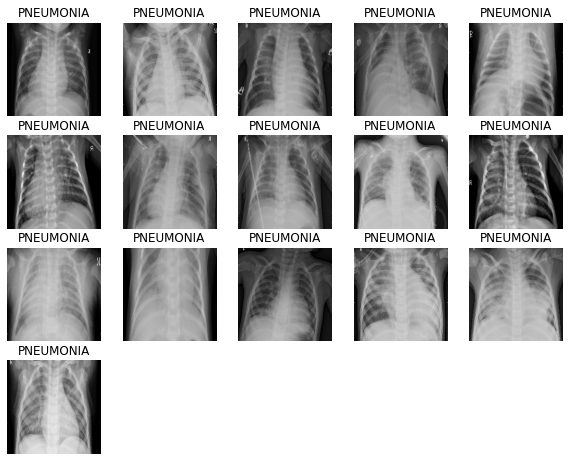

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# 모델 설계하기
## model with low rate
일단 dense 층에서 dropout을 쓰되, 기존의 dropout rate에서 0.2퍼센트 낮춘 값으로 진행했다. 

In [16]:
for image, label in train_ds.take(1):
    print(image)
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.48753816 0.48753816 0.48753816]
   [0.48746255 0.48746255 0.48746255]
   ...
   [0.46133208 0.46133208 0.46133208]
   [0.46588537 0.46588537 0.46588537]
   [0.46097445 0.46097445 0.46097445]]

  [[0.         0.         0.        ]
   [0.5054325  0.5054325  0.5054325 ]
   [0.5151816  0.5151816  0.5151816 ]
   ...
   [0.48186624 0.48186624 0.48186624]
   [0.47386238 0.47386238 0.47386238]
   [0.44747177 0.44747177 0.44747177]]

  [[0.         0.         0.        ]
   [0.51495105 0.51495105 0.51495105]
   [0.48433194 0.48433194 0.48433194]
   ...
   [0.52334154 0.52334154 0.52334154]
   [0.47555137 0.47555137 0.47555137]
   [0.5047669  0.5047669  0.5047669 ]]

  ...

  [[0.09803922 0.09803922 0.09803922]
   [0.07996732 0.07996732 0.07996732]
   [0.09060762 0.09060762 0.09060762]
   ...
   [0.05882353 0.05882353 0.05882353]
   [0.0047708  0.0047708  0.0047708 ]
   [0.         0.         0.        ]]

  [[0.08200172 0.08200172 0.082001

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    drop_rate_1 = float(0.1)
    drop_rate_2 = float(0.3)
    drop_rate_3 = float(0.5)
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        dense_block(512, drop_rate_3),
        dense_block(128, drop_rate_2),
        dense_block(64, drop_rate_1),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

weight는 그대로 넣어주기로 했다. 

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


이 외의 조건은 그대로 넣어준 채 모델을 생성한다

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 31s 117ms/step - loss: 0.3631 - accuracy: 0.8367 - precision: 0.9600 - recall: 0.8152 - val_loss: 0.7917 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 95ms/step - loss: 0.2138 - accuracy: 0.9181 - precision: 0.9759 - recall: 0.9126 - val_loss: 1.3588 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1938 - accuracy: 0.9222 - precision: 0.9742 - recall: 0.9202 - val_loss: 0.1248 - val_accuracy: 0.9538 - val_precision: 0.9447 - val_recall: 0.9947
Epoch 4/25
261/261 [==============================] - 25s 95ms/step - loss: 0.1769 - accuracy: 0.9320 - precision: 0.9803 - recall: 0.9273 - val_loss: 0.3114 - val_accuracy: 0.8712 - val_precision: 0.8493 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 25s 97ms/step - loss: 0.1373 - accuracy: 

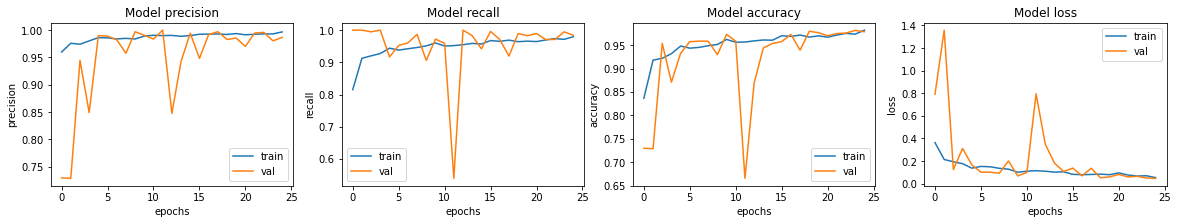

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

결과를 보아하니 accuracy가 조금 높아지긴 했지만 accuracy와 loss가 두번 크게 흔들렸던 기록이 있다. 그래서 다음 실험에서는 dropout을 아예 배제한 채로 돌려볼 예정이다. 

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 0.8467 - accuracy: 0.8141 - precision: 0.7751 - recall: 0.9897


## model without dropout

In [26]:
def build_model_without_dropout():
    drop_rate_1 = float(0.1)
    drop_rate_2 = float(0.3)
    drop_rate_3 = float(0.5)
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        dense_block(512, 0),
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [27]:
with tf.device('/GPU:0'):
    model = build_model_without_dropout()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 89ms/step - loss: 0.2485 - accuracy: 0.8994 - precision: 0.9767 - recall: 0.8864 - val_loss: 0.7012 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 97ms/step - loss: 0.1674 - accuracy: 0.9339 - precision: 0.9807 - recall: 0.9297 - val_loss: 1.5094 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1617 - accuracy: 0.9361 - precision: 0.9791 - recall: 0.9342 - val_loss: 0.4031 - val_accuracy: 0.8337 - val_precision: 0.8134 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1069 - accuracy: 0.9583 - precision: 0.9884 - recall: 0.9555 - val_loss: 0.1238 - val_accuracy: 0.9548 - val_precision: 0.9903 - val_recall: 0.9470
Epoch 5/25
261/261 [==============================] - 24s 93ms/step - loss: 0.1194 - accuracy: 0

In [29]:
def draw_history(history) :
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

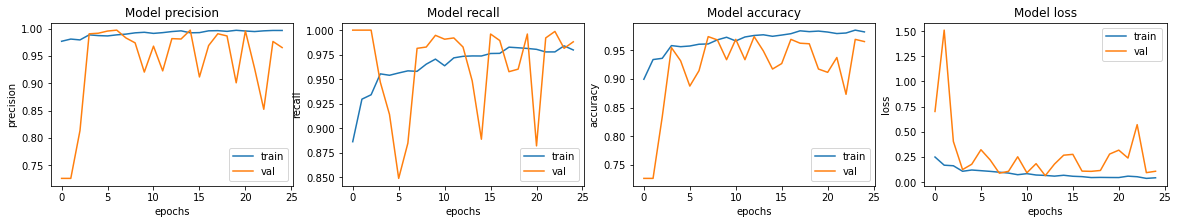

In [30]:
draw_history(history)

In [31]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 1.8732 - accuracy: 0.7260 - precision: 0.6959 - recall: 0.9974


## model with higher drop rate

dropout이 아예 없으니 모델 결과가 수렴은 하지만 계속 불안정한 모습을 보여서, 이번 실험에는 아예 dropout을 기존 실험보다 높혀서 진행해보려고 한다. 0.1%씩 올렸다. 

In [32]:
def build_model_with_high_droprate():
    drop_rate_1 = float(0.4)
    drop_rate_2 = float(0.6)
    drop_rate_3 = float(0.8)
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        dense_block(512, drop_rate_3),
        dense_block(128, drop_rate_2),
        dense_block(64, drop_rate_1),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [33]:
with tf.device('/GPU:0'):
    model = build_model_with_high_droprate()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 90ms/step - loss: 0.4821 - accuracy: 0.7438 - precision: 0.9313 - recall: 0.7088 - val_loss: 0.7289 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 90ms/step - loss: 0.2770 - accuracy: 0.8894 - precision: 0.9682 - recall: 0.8805 - val_loss: 1.1956 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 89ms/step - loss: 0.2238 - accuracy: 0.9140 - precision: 0.9772 - recall: 0.9060 - val_loss: 0.8210 - val_accuracy: 0.6990 - val_precision: 1.0000 - val_recall: 0.5860
Epoch 4/25
261/261 [==============================] - 23s 90ms/step - loss: 0.1819 - accuracy: 0.9320 - precision: 0.9800 - recall: 0.9278 - val_loss: 0.1015 - val_accuracy: 0.9625 - val_precision: 0.9626 - val_recall: 0.9868
Epoch 5/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1980 - accuracy: 0

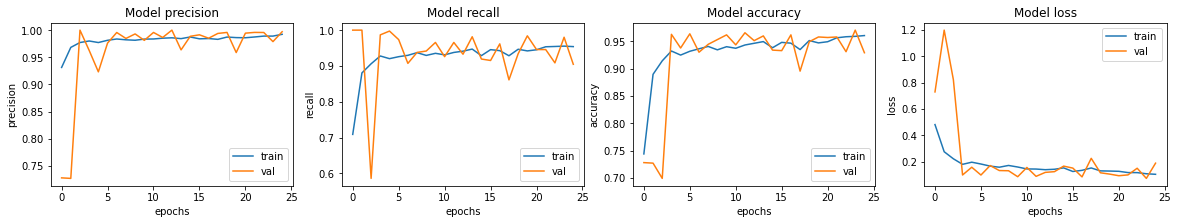

In [35]:
draw_history(history)

In [36]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 0.3927 - accuracy: 0.8718 - precision: 0.8656 - recall: 0.9410


해당 결과를 보니 최초 한번 수렴하기 전에 정확도가 낮아지는걸 제외하면 값이 수렴하고 있다. 그리고 정확도는 0.87로 높게 나왔다. 그렇다면 weight가 결과에 영향을 미치는 정도가 궁금해서, 이번 모델을 가지고 class에 weight를 주지 않고 진행하려 한다. 

## model without weight on class type

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/25
261/261 [==============================] - 24s 91ms/step - loss: 0.0965 - accuracy: 0.9665 - precision: 0.9831 - recall: 0.9718 - val_loss: 0.0504 - val_accuracy: 0.9788 - val_precision: 0.9880 - val_recall: 0.9828
Epoch 2/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1048 - accuracy: 0.9655 - precision: 0.9815 - recall: 0.9721 - val_loss: 0.0722 - val_accuracy: 0.9692 - val_precision: 0.9776 - val_recall: 0.9802
Epoch 3/25
261/261 [==============================] - 24s 90ms/step - loss: 0.0760 - accuracy: 0.9732 - precision: 0.9855 - recall: 0.9785 - val_loss: 0.0584 - val_accuracy: 0.9750 - val_precision: 0.9893 - val_recall: 0.9762
Epoch 4/25
261/261 [==============================] - 24s 91ms/step - loss: 0.0806 - accuracy: 0.9732 - precision: 0.9842 - recall: 0.9798 - val_loss: 0.0708 - val_accuracy: 0.9740 - val_precision: 0.9866 - val_recall: 0.9775
Epoch 5/25
261/261 [==============================] - 23s 89ms/step - loss: 0.0786 - accuracy: 0

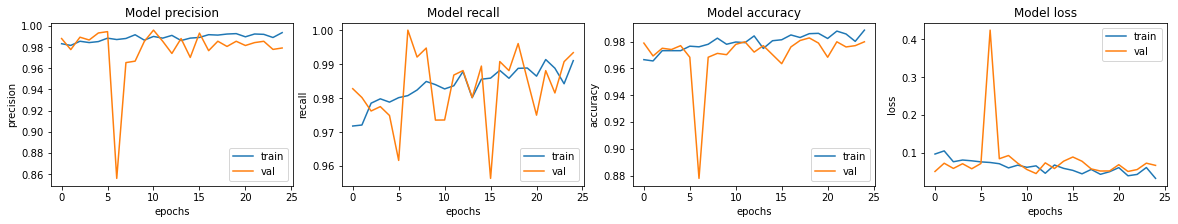

In [38]:
draw_history(history)

기록을 보니 dropout rate를 낮게 줬을때와 비슷한 양상이 일어났다. 정확도는 오히려 낮아졌다. 

In [39]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 62ms/step - loss: 1.3665 - accuracy: 0.7516 - precision: 0.7156 - recall: 1.0000


# 회고
일단 이번 경우는 데이터의 양이 적고, 그에 따라 다양한 경우를 만났을 떄 대체가 부족해보인다. 그래서 그런지 dropout과 BN을 동시에 사용한 것이 효율적이지 않았나 생각을 한다. 거기에 각 class별로 weight를 준 것이 데이터의 균형을 맞추고,augmentation과 dropout을 통해 반영되는 데이터의 특징을 조금이나마 풍부하게 만든 것이 오버피팅을 막지 않았나 생각이 든다. 